### Importing the data and the functions

In [1]:
include("importData.jl")
include("DDEmodel.jl")
include("Hill.jl")
include("ODEmodel.jl")
include("plot.jl")

# import data from the path

# population data, g2 data, g1 data, initial number of cells in g1, initial number of cells in g2
# lapatinib
conc_l, pop_l, g2_l, g1_l, g2_0_l, g1_0_l = setup_data("lapatinib");

┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = get_data(::String, ::String) at importData.jl:29
└ @ Main /home/farnazm/dde/dde-constant-delay/DrugResponseModel.jl/src/importData.jl:29
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = get_data(::String, ::String) at importData.jl:37
└ @ Main /home/farnazm/dde/dde-constant-delay/DrugResponseModel.jl/src/importData.jl:37


### A) cartoon 

In [2]:
# will do in the Affinity designer of power point

### B) ODE fitting of Lapatinib data

In [3]:
# initial values
p = [8.870525324, 8.492087169, 0.43447323, 7.67847790]

# setting lowest delay for tau1 to be half an hour and for tau2 to be 3 hours.
low = 0.0001*ones(4)
upp = 0.1*ones(4)
params_ode = zeros(4, 8)

# ODE optimization and estimation of the parameters
for i in 1:8
    params_ode[:, i] = ODEoptimizer(low, upp, p, i, g1_l, g2_l, g1_0_l, g2_0_l)
end

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 10001 steps and 0.75 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 13298.19
Function evals per second = 13427.17
Improvements/step = 0.19080
Total function evaluations = 10098


Best candidate found: [0.0435478, 0.0239064, 0.000100001, 0.000100028]

Fitness: 271.617928428

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 10001 steps and 0.60 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 16646.83
Function evals per second = 16853.23
Improvements/step = 0.19850
Total function evaluations = 10125


Best candidate f

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = ode_plotIt(::Array{Float64,1}, ::Array{Float64,2}, ::Array{Float64,2}, ::Array{Float64,1}, ::Array{Float64,1}, ::DataFrame, ::Int64, ::String, ::Symbol) at ODEmodel.jl:57
└ @ Main /home/farnazm/dde/dde-constant-delay/DrugResponseModel.jl/src/ODEmodel.jl:57
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = ode_plotIt(::Array{Float64,1}, ::Array{Float64,2}, ::Array{Float64,2}, ::Array{Float64,1}, ::Array{Float64,1}, ::DataFrame, ::Int64, ::String, ::Bool) at ODEmodel.jl:57
└ @ Main /home/farnazm/dde/dde-constant-delay/DrugResponseModel.jl/src/ODEmodel.jl:57


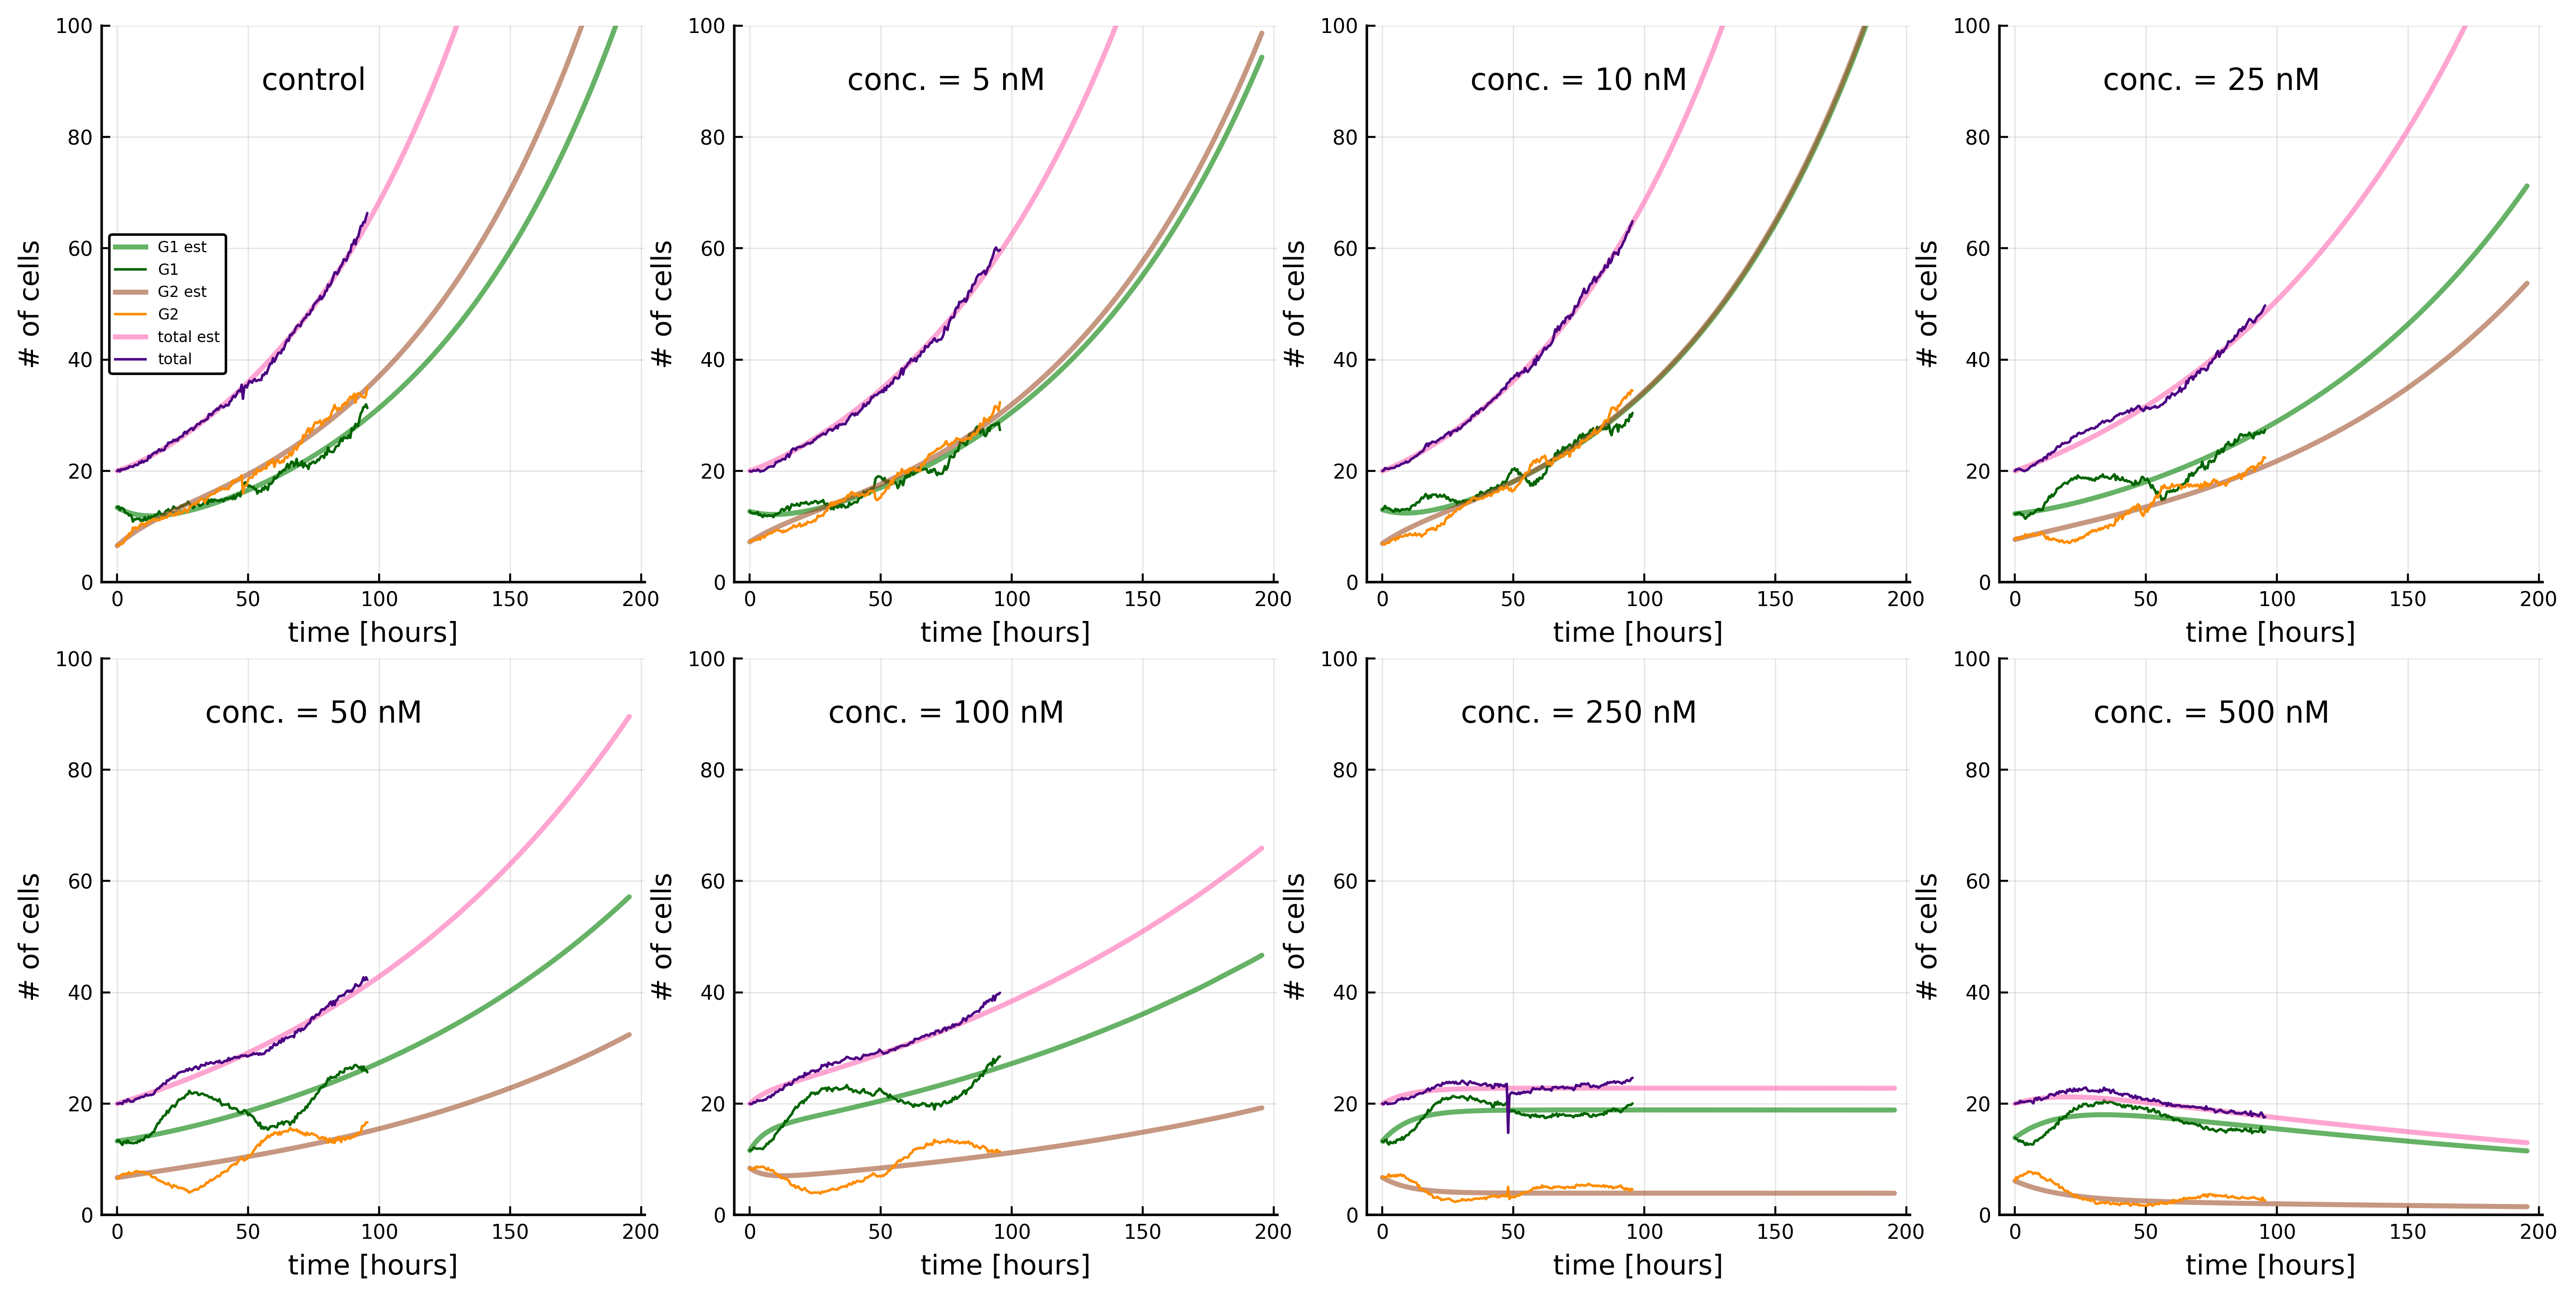

In [4]:
r1 = ode_plotIt(params_ode[:, 1], g1_l, g2_l, g1_0_l, g2_0_l, pop_l, 1, "control", :left)
r2 = ode_plotIt(params_ode[:, 2], g1_l, g2_l, g1_0_l, g2_0_l, pop_l, 2, "conc. = 5 nM", false)
r3 = ode_plotIt(params_ode[:, 3], g1_l, g2_l, g1_0_l, g2_0_l, pop_l, 3, "conc. = 10 nM", false)
r4 = ode_plotIt(params_ode[:, 4], g1_l, g2_l, g1_0_l, g2_0_l, pop_l, 4, "conc. = 25 nM", false)
r5 = ode_plotIt(params_ode[:, 5], g1_l, g2_l, g1_0_l, g2_0_l, pop_l, 5, "conc. = 50 nM", false)
r6 = ode_plotIt(params_ode[:, 6], g1_l, g2_l, g1_0_l, g2_0_l, pop_l, 6, "conc. = 100 nM", false)
r7 = ode_plotIt(params_ode[:, 7], g1_l, g2_l, g1_0_l, g2_0_l, pop_l, 7, "conc. = 250 nM", false)
r8 = ode_plotIt(params_ode[:, 8], g1_l, g2_l, g1_0_l, g2_0_l, pop_l, 8, "conc. = 500 nM", false)
plot(r1, r2, r3, r4, r5, r6, r7, r8, layout = (2,4))
plot!(size=(1400, 700), dpi = 400,layout=(2,4))
ylims!((0.0, 100.0))
# savefig("odefit.png")

### F) DDE fitting for lapatinib

In [5]:
# initial guess
initial_guess  = [0.02798, 0.025502, 15.3481, 15.2881, 0.001, 0.001]

# bounds 
lower_bnd = [-6.0, -6.0, 1.0, 1.0, -10.0, -10.0]
upper_bnd = [0.0, 0.0, 6.0, 6.0, 0.0, 0.0]

# max number of steps
maxSteps = 1e4
parameters = zeros(6,8)
for j in 1:8
    println("#################### trial number $j #########################")
    best_fit, parameters[:,j] = optimization(g1_l, g2_l, g1_0_l, g2_0_l, initial_guess, j, lower_bnd, upper_bnd, maxSteps)
end


#################### trial number 1 #########################
blackbox optim begins ...
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 10001 steps and 43.45 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 230.20
Function evals per second = 232.96
Improvements/step = 0.24030
Total function evaluations = 10121


Best candidate found: [-3.10698, -3.70046, 1.0, 1.00048, -9.9809, -9.99894]

Fitness: 308.250685496

fitness before local optimization:  
308.2506854964433
#################### trial number 2 #########################
blackbox optim begins ...
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped afte

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = plotIt(::Array{Float64,1}, ::Int64, ::String, ::Symbol) at plot.jl:34
└ @ Main /home/farnazm/dde/dde-constant-delay/DrugResponseModel.jl/src/plot.jl:34
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = plotIt(::Array{Float64,1}, ::Int64, ::String, ::Bool) at plot.jl:34
└ @ Main /home/farnazm/dde/dde-constant-delay/DrugResponseModel.jl/src/plot.jl:34


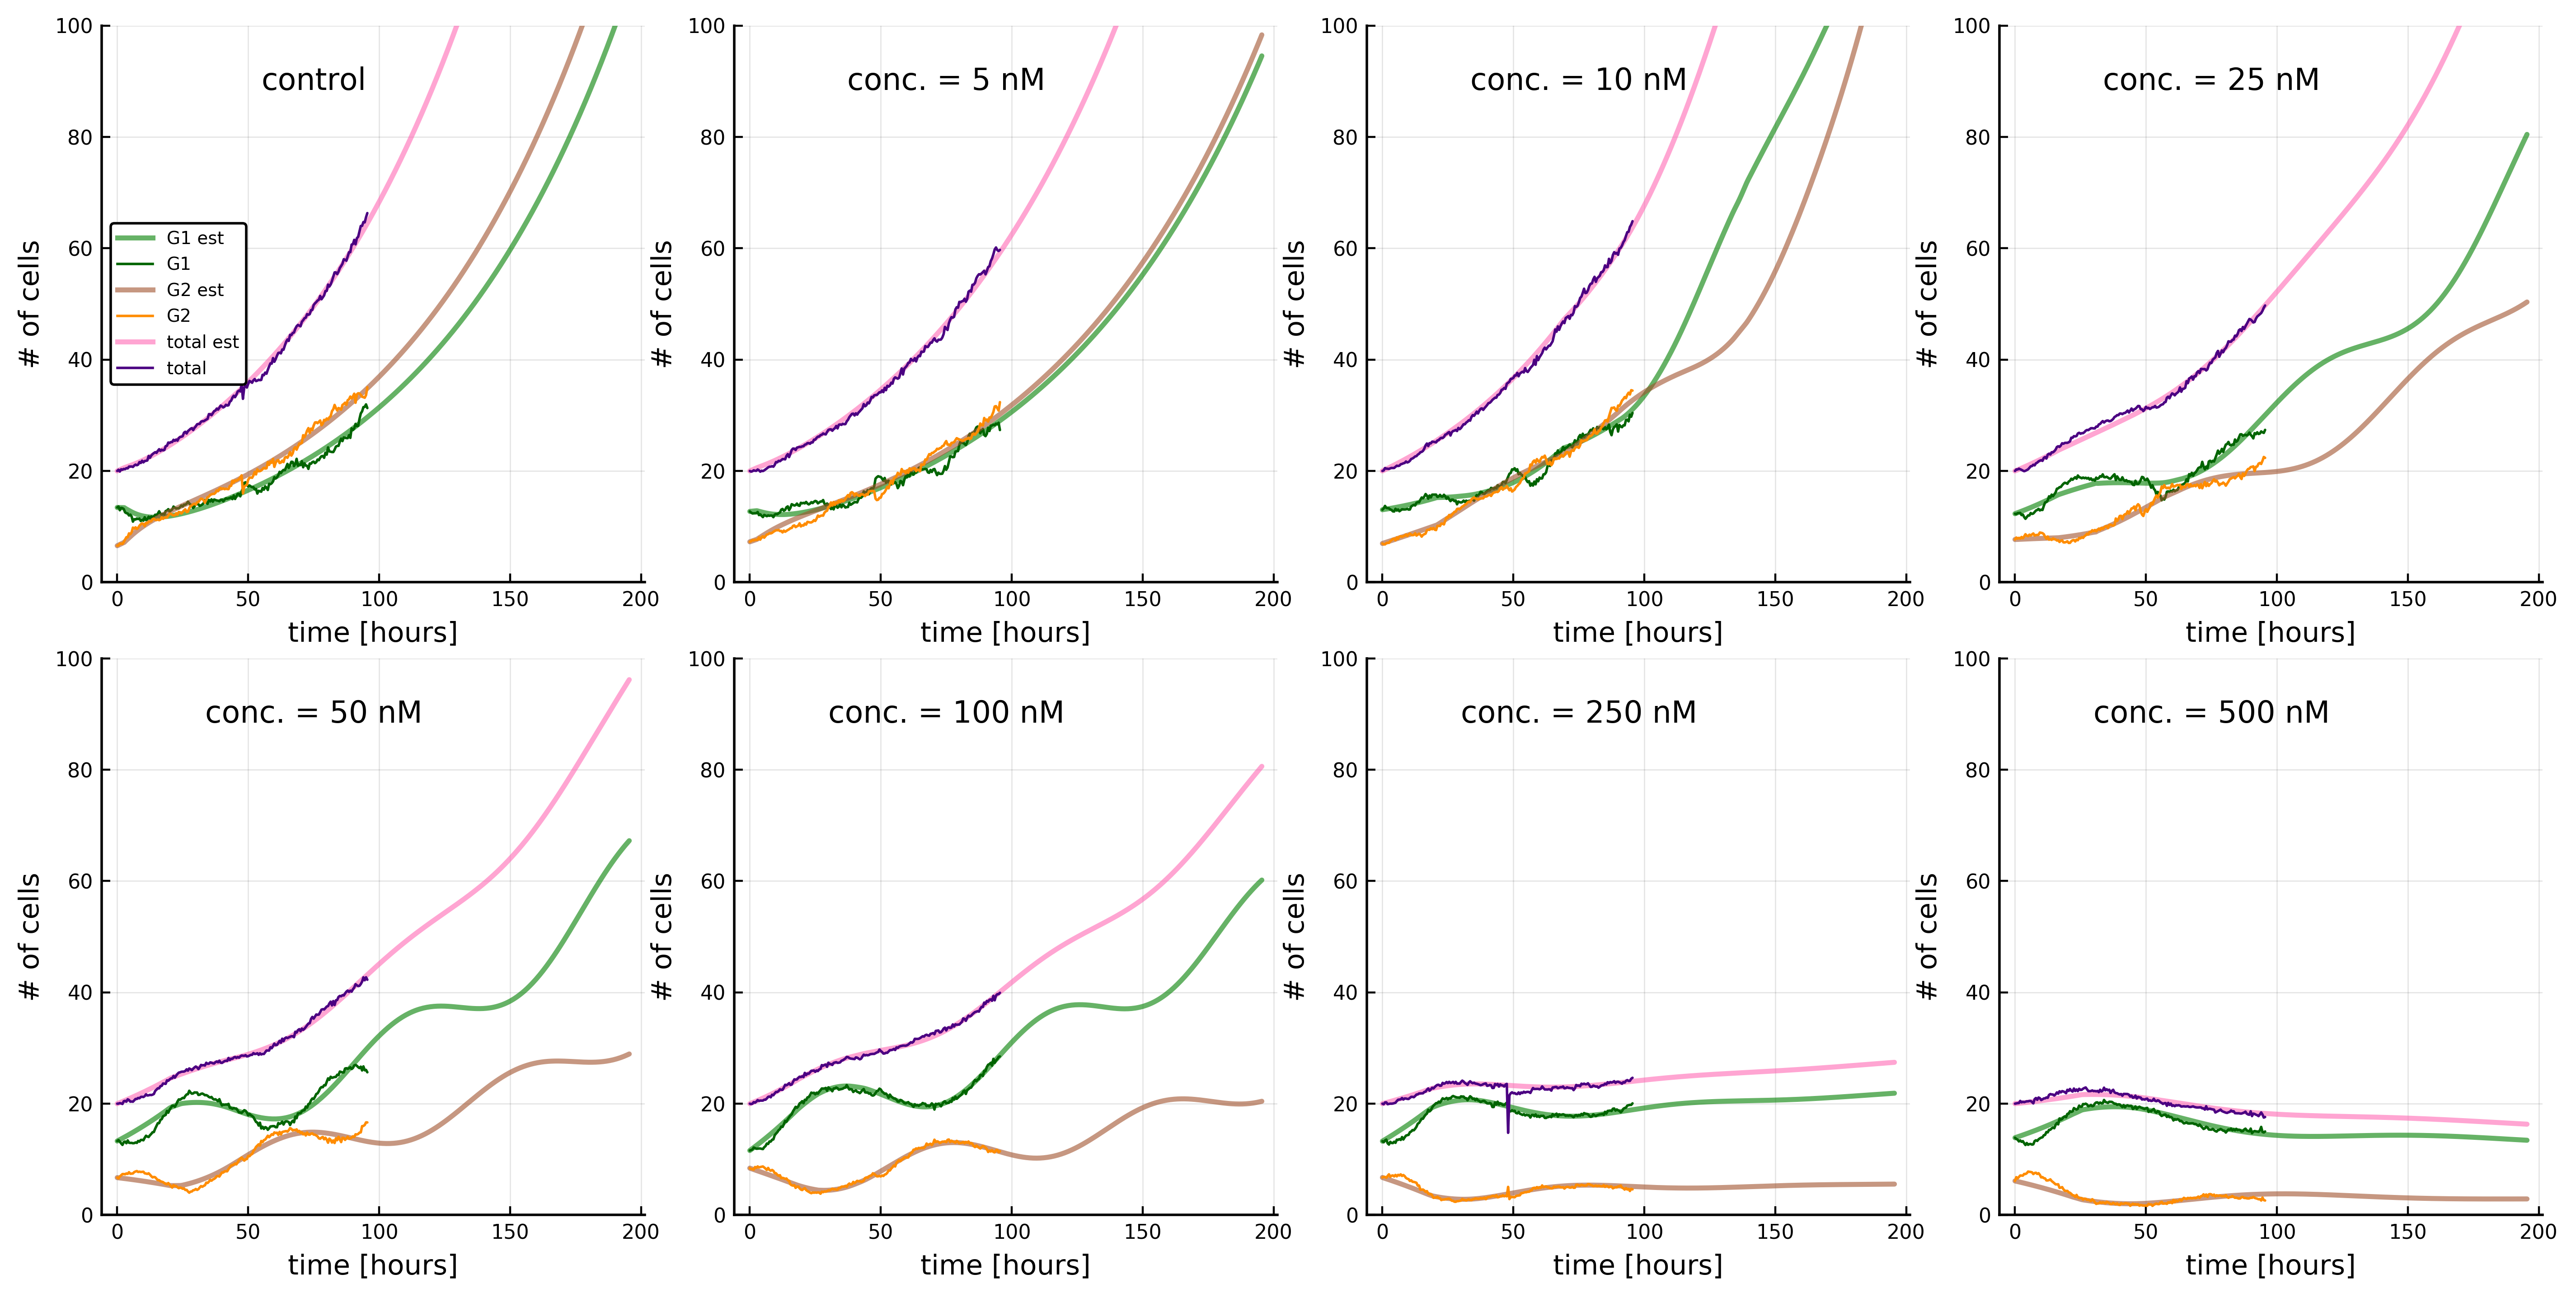

In [6]:
# i showas the trial number, which could be from 1:control, ..., 8: maximum drug concentraation
p1 = plotIt(parameters[:, 1], 1, "control", :left)
p2 = plotIt(parameters[:, 2], 2, "conc. = 5 nM", false)
p3 = plotIt(parameters[:, 3], 3, "conc. = 10 nM", false)
p4 = plotIt(parameters[:, 4], 4, "conc. = 25 nM", false)
p5 = plotIt(parameters[:, 5], 5, "conc. = 50 nM", false)
p6 = plotIt(parameters[:, 6], 6, "conc. = 100 nM", false)
p7 = plotIt(parameters[:, 7], 7, "conc. = 250 nM", false)
p8 = plotIt(parameters[:, 8], 8, "conc. = 500 nM", false)
plot(p1, p2, p3, p4, p5, p6, p7, p8, layout = (2,4))
plot!(size = (1400, 700), dpi = 400)
ylims!((0.0, 100.0))
# savefig("ddefit.png")

### G) DDE parameters for lapatinib

In [7]:
# make the concentration in the plots as log scale
conc = [0.25, 5.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0]
log_conc = log.(conc)

8-element Array{Float64,1}:
 -1.3862943611198906
  1.6094379124341003
  2.302585092994046 
  3.2188758248682006
  3.912023005428146 
  4.605170185988092 
  5.521460917862246 
  6.214608098422191 

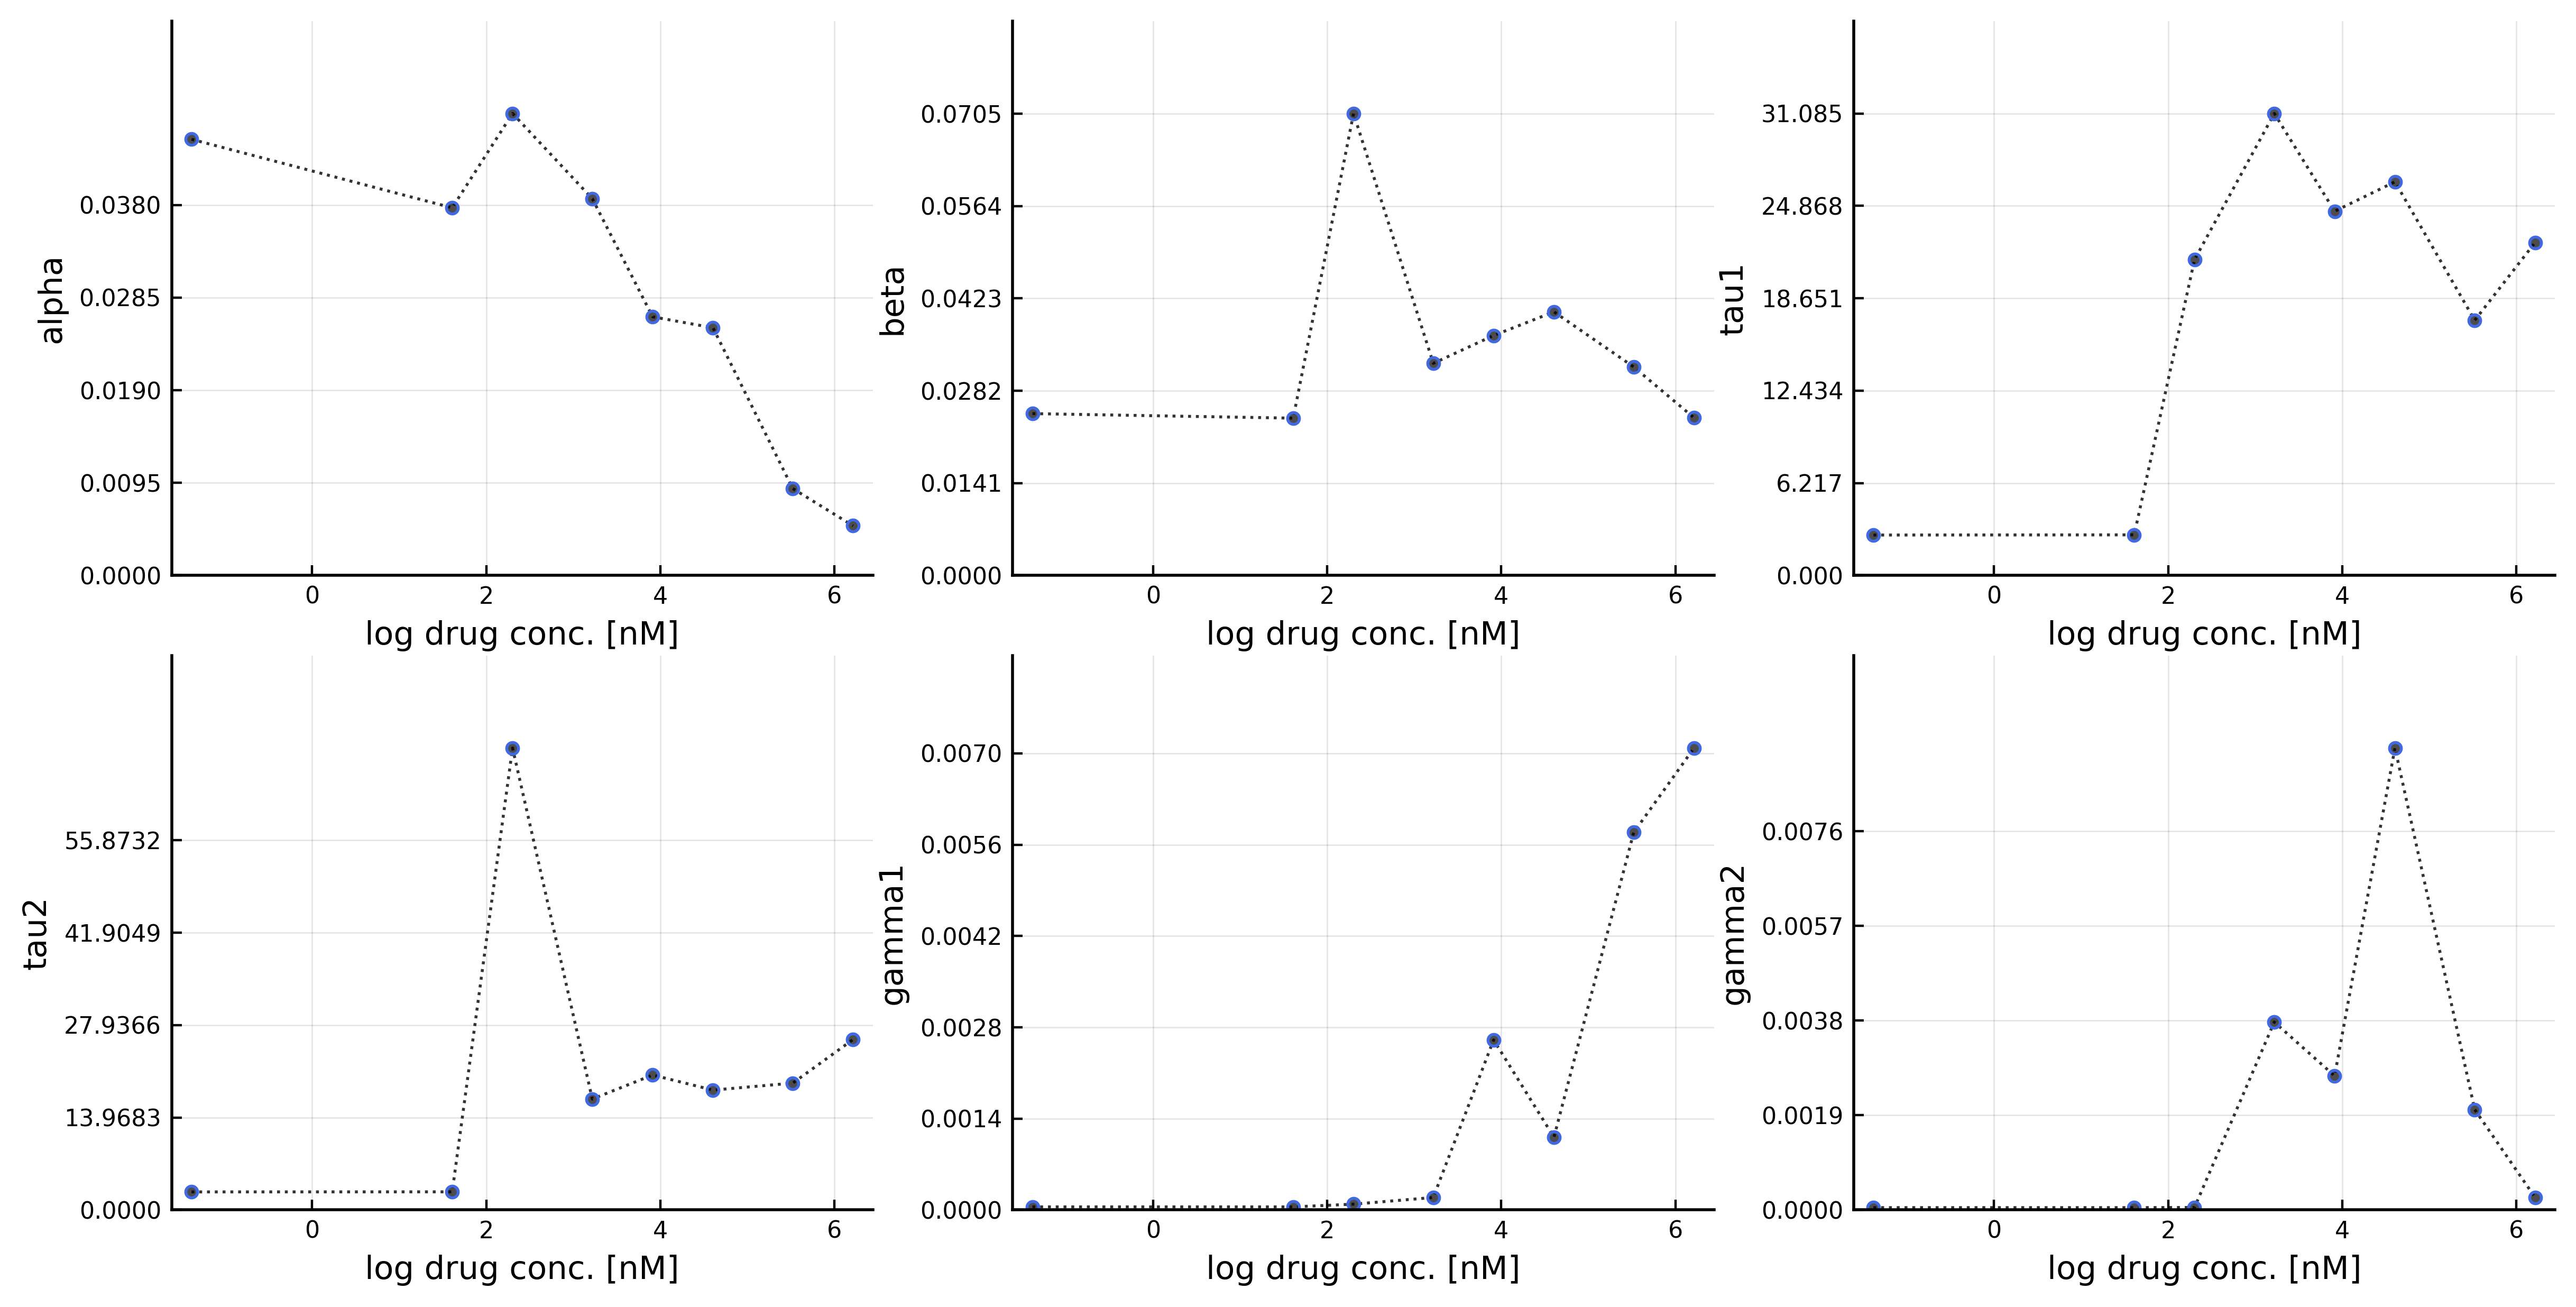

In [22]:
p1 = plot(log_conc, parameters[1,:], xlabel = "log drug conc. [nM]", label="", lw= 3.0, alpha = 0.8, color=[:black :royalblue], line=(:dot, 1), marker=([:dot :d], 4, 0.7, stroke(0.1, 0.6, :royalblue)),
    ylabel = "alpha", yticks = 0.0:round(maximum(parameters[1,:])/5 ,digits = 4):maximum(parameters[1,:])); ylims!((0.0, 1.2*maximum(parameters[1,:])))

p2 = plot(log_conc, parameters[2,:], xlabel = "log drug conc. [nM]", label = "", lw= 3.0, alpha = 0.8, color=[:black :royalblue], line=(:dot, 1), marker=([:dot :d], 4, 0.7, stroke(0.1, 0.6, :royalblue)),
    ylabel = "beta", yticks = 0.0:round(maximum(parameters[2,:])/5 ,digits = 4):maximum(parameters[2,:])); ylims!((0.0, 1.2*maximum(parameters[2,:])))

p3 = plot(log_conc, parameters[3,:], xlabel = "log drug conc. [nM]", label="", lw= 3.0, alpha = 0.8, color=[:black :royalblue], line=(:dot, 1), marker=([:dot :d], 4, 0.7, stroke(0.1, 0.6, :royalblue)),
    ylabel = "tau1", yticks = 0.0:round(maximum(parameters[3,:])/5 ,digits = 4):maximum(parameters[3,:])); ylims!((0.0, 1.2*maximum(parameters[3,:])))

p4 = plot(log_conc, parameters[4,:], xlabel = "log drug conc. [nM]", label = "", lw= 3.0, alpha = 0.8, color=[:black :royalblue], line=(:dot, 1), marker=([:dot :d], 4, 0.7, stroke(0.1, 0.6, :royalblue)),
    ylabel = "tau2", yticks = 0.0:round(maximum(parameters[4,:])/5 ,digits = 4):maximum(parameters[4,:])); ylims!((0.0, 1.2*maximum(parameters[4,:])))

p5 = plot(log_conc, parameters[5,:], xlabel = "log drug conc. [nM]", label = "", lw= 3.0, alpha = 0.8, color=[:black :royalblue], line=(:dot, 1), marker=([:dot :d], 4, 0.7, stroke(0.1, 0.6, :royalblue)),
    ylabel = "gamma1", yticks = 0.0:round(maximum(parameters[5,:])/5 ,digits = 4):maximum(parameters[5,:])); ylims!((0.0, 1.2*maximum(parameters[5,:])))

p6 = plot(log_conc, parameters[6,:], xlabel = "log drug conc. [nM]", label = "", lw= 3.0, alpha = 0.8, color=[:black :royalblue], line=(:dot, 1), marker=([:dot :d], 4, 0.7, stroke(0.1, 0.6, :royalblue)),
    ylabel = "gamma2", yticks = 0.0:round(maximum(parameters[6,:])/5 ,digits = 4):maximum(parameters[6,:])); ylims!((0.0, 1.2*maximum(parameters[6,:])))

plot(p1, p2, p3, p4, p5, p6, dpi = 400,layout=(2,3))
plot!(size = (1200, 600))
# savefig("drugefdde.png")

### H) Hill fitting 

In [15]:
#  [EC50, b_steepness, alpha_min, alpha_max, beta_min, beta_max, tau1_mean, tau1_max, tau2_min, tau2_max, gamma1_max, gamma2_max]
# guess
include("Hill.jl")
# guess = [150.0, 0.097836, 0.00682578, 0.00958013, 0.00503788, 0.0433964, 38.941, 9.94827, 0.00294624, 0.0222821]
guess = [125.0, 0.002, 0.007, 0.005, 0.007, 0.005, 25.0, 5.0, 0.003, 0.02]
# max num of steps
num_steps=500

best_fit, params = optimize_hill(guess, conc_l, g1_l, g2_l, g1_0_l, g2_0_l, num_steps)


# easy way to convert the hill parameters to DDE parameters
p = getDDEparams(params, conc_l)

global optimization begins ...
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
50.11 secs, 359 evals, 274 steps, improv/step: 0.449 (last = 0.4489), fitness=682742.354248390

Optimization stopped after 501 steps and 82.08 seconds
Termination reason: Max number of steps (500) reached
Steps per second = 6.10
Function evals per second = 7.16
Improvements/step = 0.43200
Total function evaluations = 588


Best candidate found: [57.7516, 0.00215391, 0.0145552, 0.0507052, 0.176925, 0.0152081, 20.7053, 4.63746, 0.00700924, 0.0623751]

Fitness: 681134.468686838



6×8 Array{Float64,2}:
  0.0352012    0.0349812    0.0347606   …   0.0246117    0.0181828 
  0.0845651    0.085549     0.0865361       0.131937     0.160697  
 20.7053      20.7053      20.7053         20.7053      20.7053    
  4.63746      4.63746      4.63746         4.63746      4.63746   
  0.00300612   0.00304877   0.00309155      0.00505935   0.00630587
  0.0267514    0.0271309    0.0275117   …   0.0450231    0.0561158 

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = plotIt(::Array{Float64,1}, ::Int64, ::String, ::Symbol) at plot.jl:34
└ @ Main /home/farnazm/dde/dde-constant-delay/DrugResponseModel.jl/src/plot.jl:34
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = plotIt(::Array{Float64,1}, ::Int64, ::String, ::Bool) at plot.jl:34
└ @ Main /home/farnazm/dde/dde-constant-delay/DrugResponseModel.jl/src/plot.jl:34


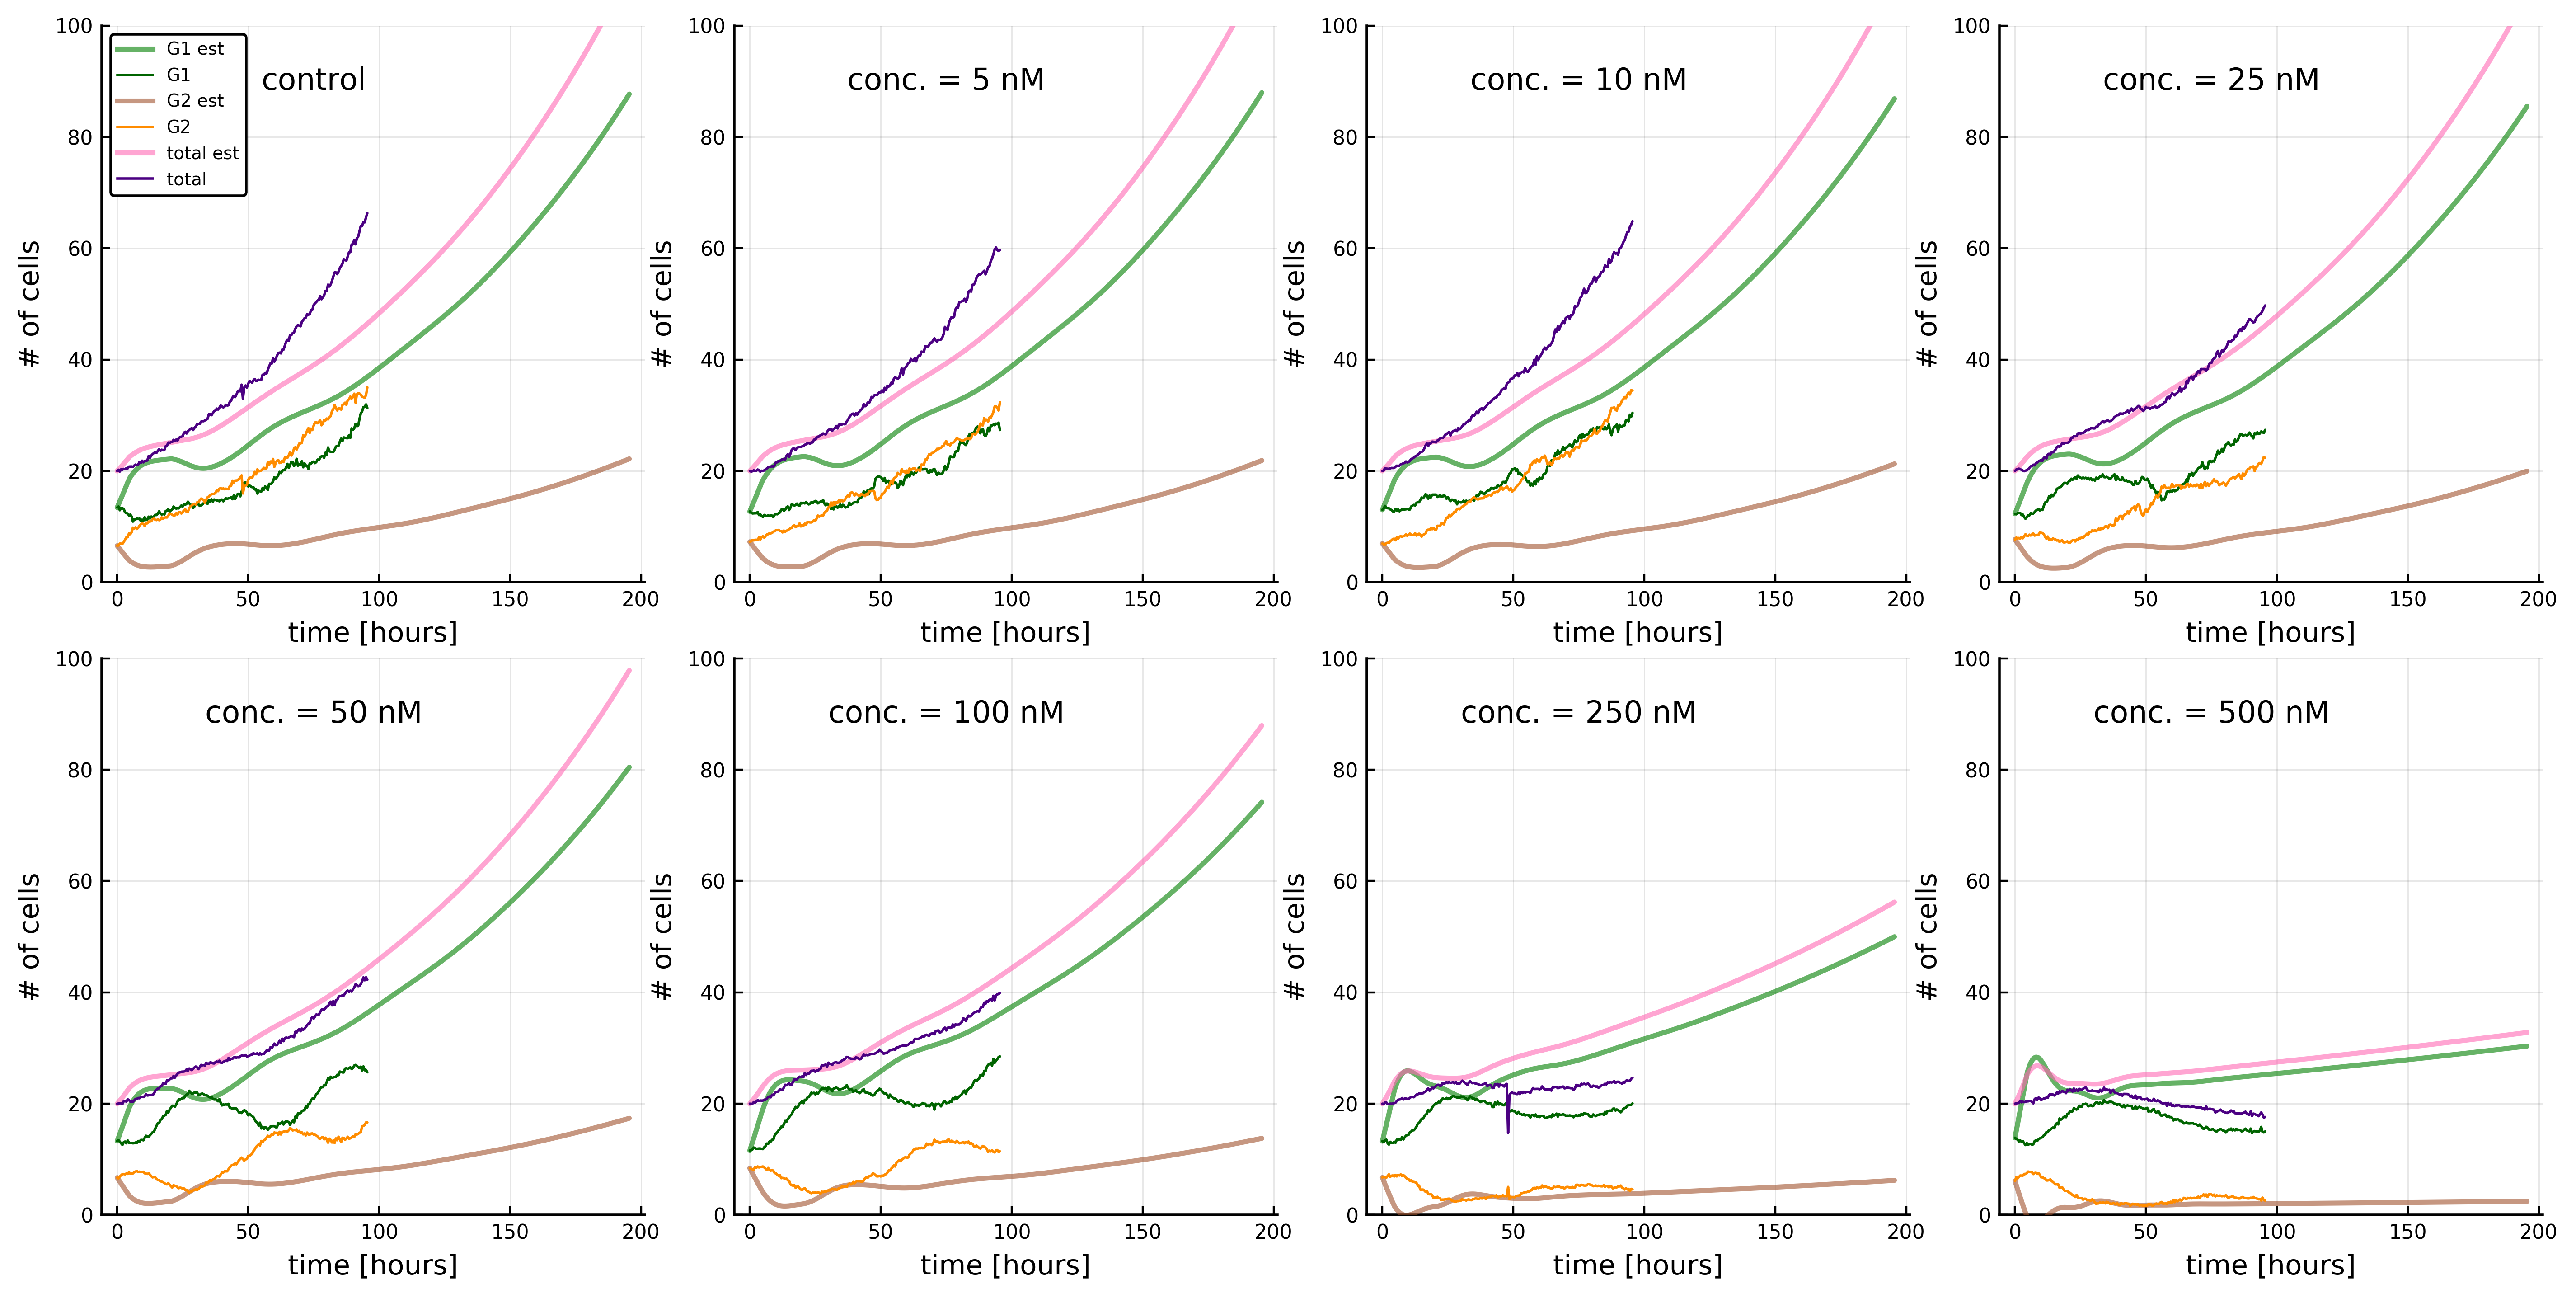

In [16]:
# for instance we want to plot the data and estimated for some trial 
p1 = plotIt(p[:, 1], 1, "control", :topleft)
p2 = plotIt(p[:, 2], 2, "conc. = 5 nM", false)
p3 = plotIt(p[:, 3], 3, "conc. = 10 nM", false)
p4 = plotIt(p[:, 4], 4, "conc. = 25 nM", false)
p5 = plotIt(p[:, 5], 5, "conc. = 50 nM", false)
p6 = plotIt(p[:, 6], 6, "conc. = 100 nM", false)
p7 = plotIt(p[:, 7], 7, "conc. = 250 nM", false)
p8 = plotIt(p[:, 8], 8, "conc. = 500 nM", false)
plot(p1, p2, p3, p4, p5, p6, p7, p8, dpi=400, layout=(2,4))
plot!(size = (1400, 700))
ylims!((0.0, 100.0))
# savefig("hillfit.png")

### I) DDE Hill Parameters

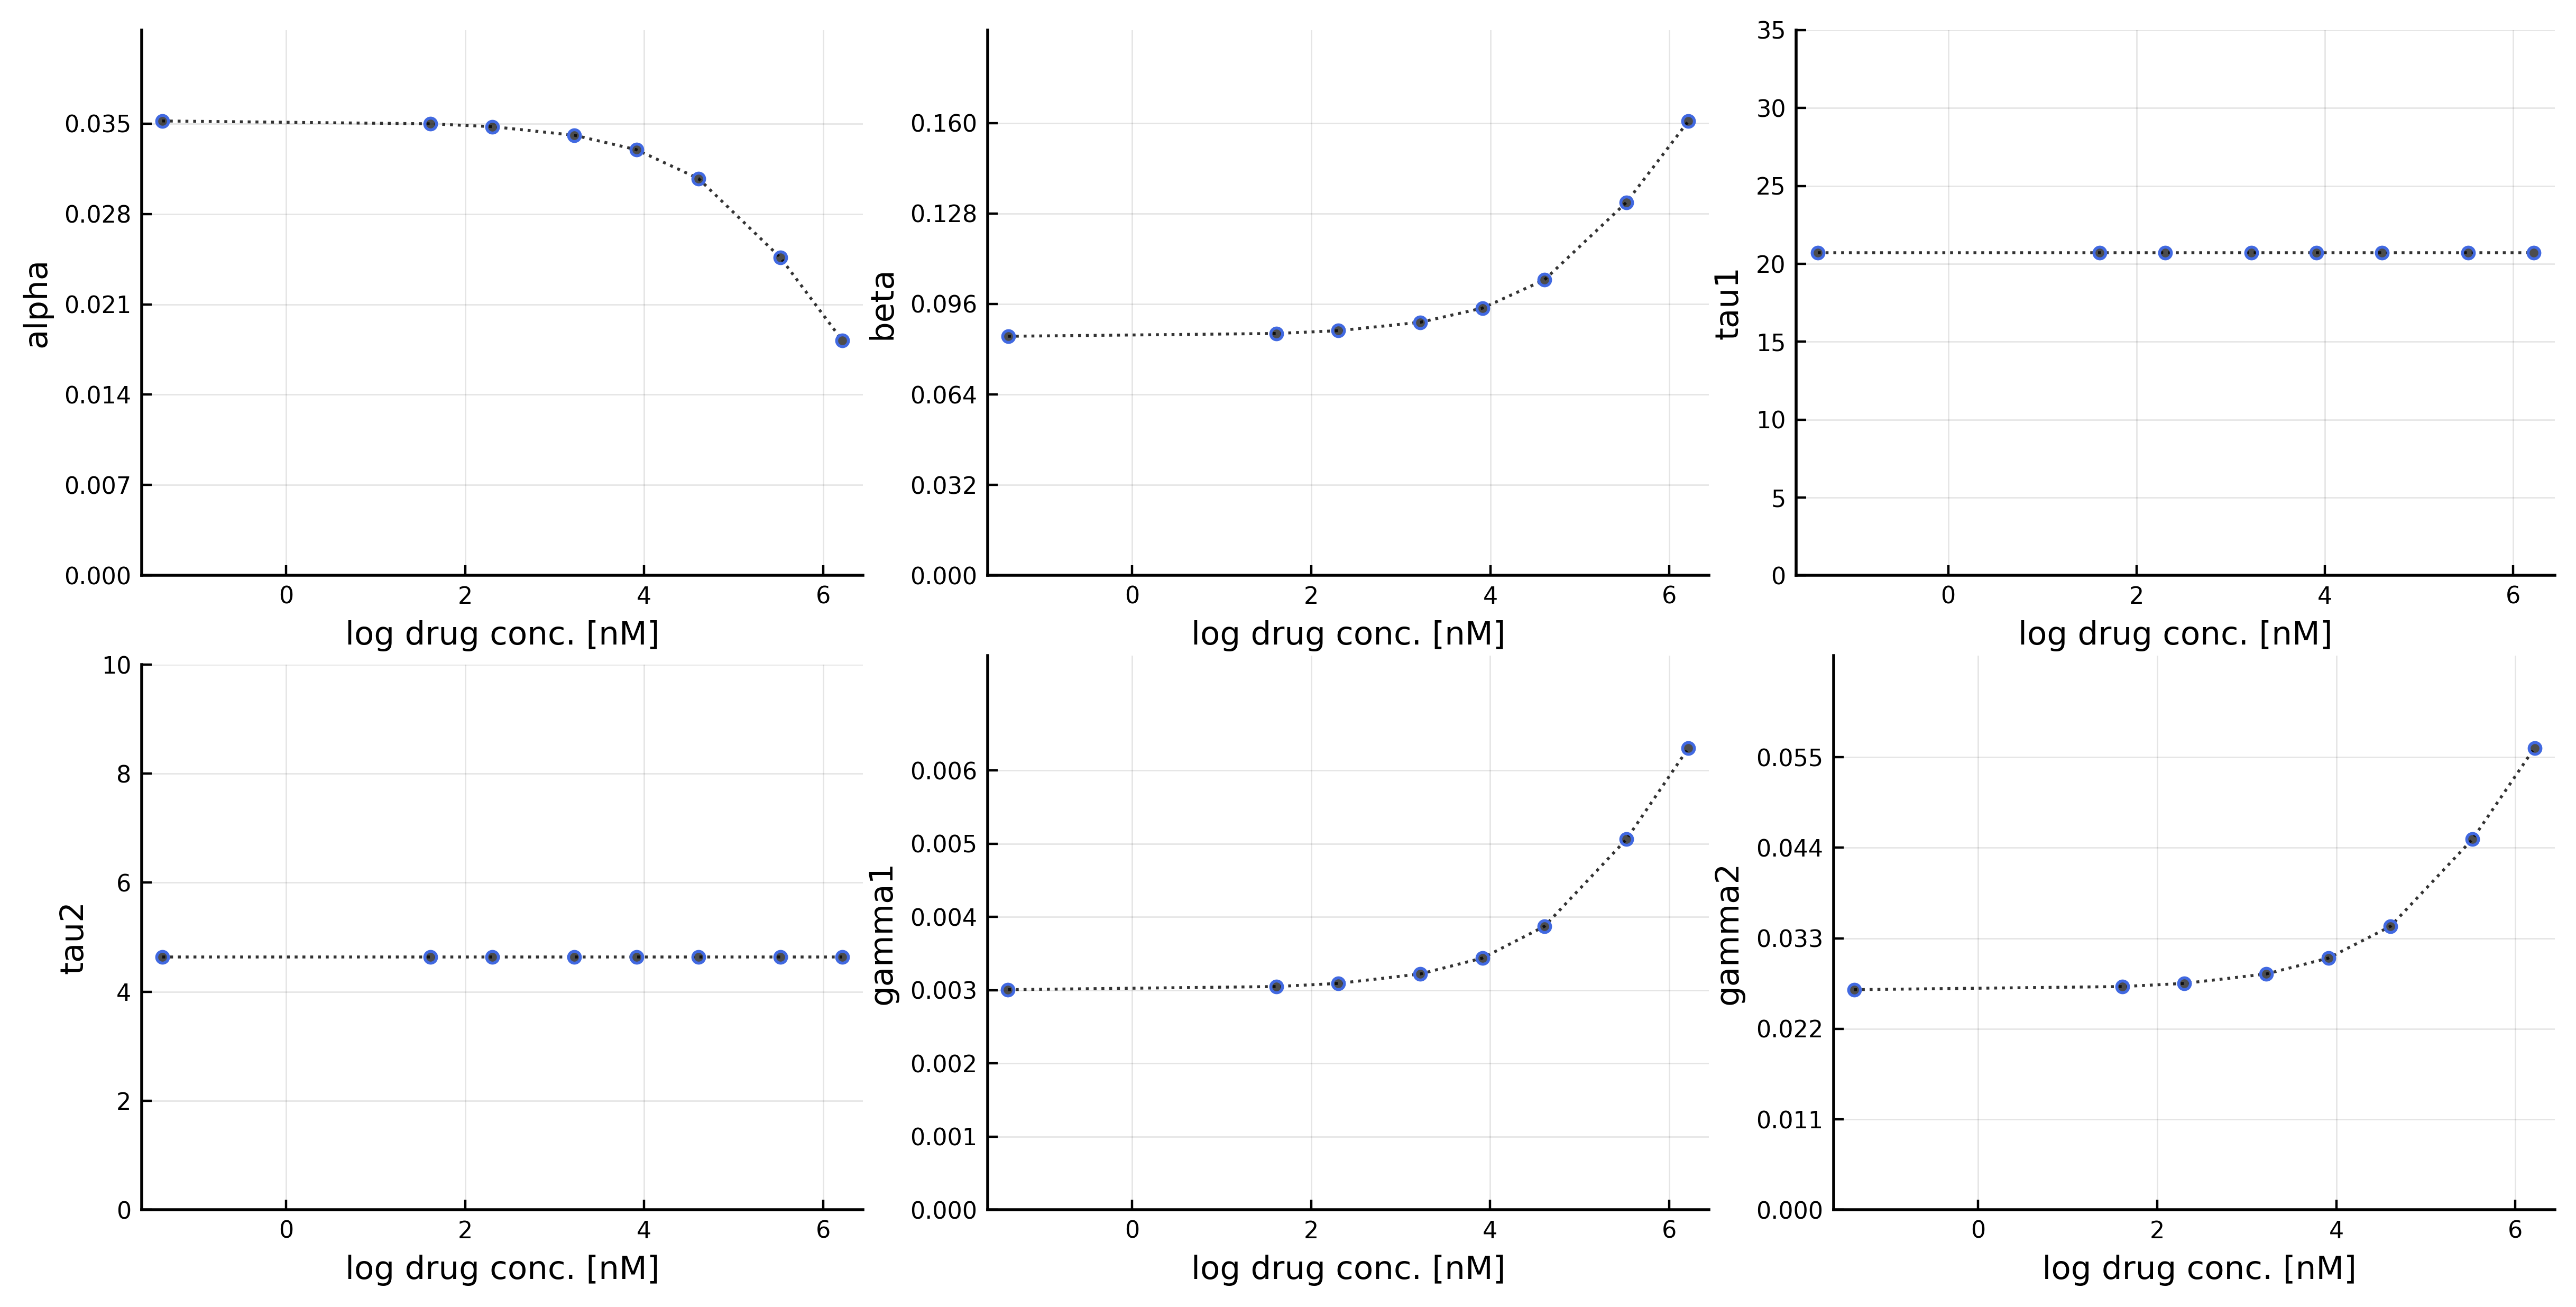

In [21]:
pp1 = plot(log_conc, p[1,:], xlabel = "log drug conc. [nM]", label="", lw= 3.0, alpha = 0.8, color=[:black :royalblue], line=(:dot, 1), marker=([:dot :d], 4, 0.7, stroke(0.1, 0.6, :royalblue)),
    ylabel = "alpha", yticks = 0.0:round(maximum(p[1,:])/5 ,digits = 3):maximum(p[1,:])); ylims!((0.0, 1.2 * maximum(p[1,:])))

pp2 = plot(log_conc, p[2,:], xlabel = "log drug conc. [nM]", label = "",  lw= 3.0, alpha = 0.8, color=[:black :royalblue], line=(:dot, 1), marker=([:dot :d], 4, 0.7, stroke(0.1, 0.6, :royalblue)),
    ylabel = "beta", yticks = 0.0:round(maximum(p[2,:])/5 ,digits = 3):maximum(p[2,:])); ylims!((0.0, 1.2 * maximum(p[2,:])))

pp3 = plot(log_conc, p[3,:], xlabel = "log drug conc. [nM]", label="", lw= 3.0, alpha = 0.8, color=[:black :royalblue], line=(:dot, 1), marker=([:dot :d], 4, 0.7, stroke(0.1, 0.6, :royalblue)),
    ylabel = "tau1"); ylims!((0.0, 35.0))

pp4 = plot(log_conc, p[4,:], xlabel = "log drug conc. [nM]", label = "",  lw= 3.0, alpha = 0.8, color=[:black :royalblue], line=(:dot, 1), marker=([:dot :d], 4, 0.7, stroke(0.1, 0.6, :royalblue)),
    ylabel = "tau2"); ylims!((0.0, 10.0))

pp5 = plot(log_conc, p[5,:], xlabel = "log drug conc. [nM]", label = "",  lw= 3.0, alpha = 0.8, color=[:black :royalblue], line=(:dot, 1), marker=([:dot :d], 4, 0.7, stroke(0.1, 0.6, :royalblue)),
    ylabel = "gamma1", yticks = 0.0:round(maximum(p[5,:])/5 ,digits = 3):maximum(p[5,:])); ylims!((0.0, 1.2 * maximum(p[5,:])))

pp6 = plot(log_conc, p[6,:], xlabel = " log drug conc. [nM]", label = "", lw= 3.0, alpha = 0.8, color=[:black :royalblue], line=(:dot, 1), marker=([:dot :d], 4, 0.7, stroke(0.1, 0.6, :royalblue)),
    ylabel = "gamma2", yticks = 0.0:round(maximum(p[6,:])/5 ,digits = 3):maximum(p[6,:])); ylims!((0.0, 1.2 * maximum(p[6,:])))

plot(pp1, pp2, pp3, pp4, pp5, pp6, dpi = 400,layput=(2,3))
plot!(size = (1200, 600))
# savefig("drugeffhill.png")